In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [41]:
# read data
train = pd.read_csv('input-rss/train.csv')
store = pd.read_csv('input-rss/store.csv')
test = pd.read_csv('input-rss/test.csv')

/var/folders/_y/hzd68ny17rsfgx2sq7wtmxcw0000gn/T/ipykernel_921/309179011.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('input-rss/train.csv')


In [42]:
print(store.info()) 
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dty

### Store
- CompetitionDistance (3 null) mit durchschnitt eintragen
- CompetitionOpenSinceMonth -> gelöscht
- CompetitionOpenSinceYear -> gelöscht
- Promo2 -> 0: kein Promo2, 
            1: Promo2 aktiv -> Promo2SinceWeek, Promo2SinceYear, PromoInterval

### Train
- Date -> Datum; Änderung in Datetime bzw. Jahr, Monat, Tag, Woche, Tag im Jahr, Tag der Woche, Feiertag
- StateHoliday -> 0: kein Feiertag, a: Feiertag (Gesetzlich), b: Feiertag (Ostern), c: Feiertag (Christmas); Änderung in 0, 1, 2, 3
- SchoolHoliday -> 0: kein Schulferien, 1: Schulferien

In [43]:
# data cleaning
# fill missing CompetitionDistance with mean
store['CompetitionDistance'].fillna(store['CompetitionDistance'].mean(), inplace=True)

In [44]:
# drop columns 4 and 5 of store
store.drop(store.columns[[4,5]], axis=1, inplace=True)

In [45]:
# map strings to categorical values
store['StoreType'] = store['StoreType'].map({'a':0, 'b':1, 'c':2, 'd':3})
store['Assortment'] = store['Assortment'].map({'a':0, 'b':1, 'c':2})
store.head()


,Store,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,2,0,1270.0,0,NaN,NaN,NaN
1,2,0,0,570.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,0,0,14130.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,2,2,620.0,0,NaN,NaN,NaN
4,5,0,0,29910.0,0,NaN,NaN,NaN


Label Encoding:

In [46]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
store['PromoInterval'] = le.fit_transform(store['PromoInterval'].astype(str))
store['Promo2SinceWeek'] = le.fit_transform(store['Promo2SinceWeek'].astype(str))
store['Promo2SinceYear'] = le.fit_transform(store['Promo2SinceYear'].astype(str))

In [47]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,2,0,1270.0,0,24,7,3
1,2,0,0,570.0,1,2,1,1
2,3,0,0,14130.0,1,3,2,1
3,4,2,2,620.0,0,24,7,3
4,5,0,0,29910.0,0,24,7,3


# Data Cleaning Train & Test Data

In [48]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [49]:
train['StateHoliday'] = le.fit_transform(train['StateHoliday'].astype(str))
print(train.head())

test['StateHoliday'] = le.fit_transform(test['StateHoliday'].astype(str))
test['Open'] = le.fit_transform(test['Open'].astype(str))
print(test.head())

   Store  DayOfWeek        Date  Sales  Customers  Open  Promo  StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1             0   
1      2          5  2015-07-31   6064        625     1      1             0   
2      3          5  2015-07-31   8314        821     1      1             0   
3      4          5  2015-07-31  13995       1498     1      1             0   
4      5          5  2015-07-31   4822        559     1      1             0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  
   Id  Store  DayOfWeek        Date  Open  Promo  StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17     1      1             0              0
1   2      3          4  2015-09-17     1      1             0              0
2   3      7          4  2015-09-17     1      1             0              0
3   4      8          4  2015-09-17     1      1             0              0
4   5      9   

Date bei beiden in Datetime umwandeln und dann in Jahr, Monat, Tag, Woche, Tag im Jahr, Tag der Woche, Feiertag aufsplitten

In [50]:
# split date into year, month, day
train['Date'] = pd.to_datetime(train['Date'])
train['Date_Year'] = train['Date'].dt.year
train['Date_Month'] = train['Date'].dt.month
train['Date_Day'] = train['Date'].dt.day
train = train.drop('Date', axis=1)

# split date into year, month, day
test['Date'] = pd.to_datetime(test['Date'])
test['Date_Year'] = test['Date'].dt.year
test['Date_Month'] = test['Date'].dt.month
test['Date_Day'] = test['Date'].dt.day
test = test.drop('Date', axis=1)


In [51]:
print(train.head())
print(test.head())

   Store  DayOfWeek  Sales  Customers  Open  Promo  StateHoliday  \
0      1          5   5263        555     1      1             0   
1      2          5   6064        625     1      1             0   
2      3          5   8314        821     1      1             0   
3      4          5  13995       1498     1      1             0   
4      5          5   4822        559     1      1             0   

   SchoolHoliday  Date_Year  Date_Month  Date_Day  
0              1       2015           7        31  
1              1       2015           7        31  
2              1       2015           7        31  
3              1       2015           7        31  
4              1       2015           7        31  
   Id  Store  DayOfWeek  Open  Promo  StateHoliday  SchoolHoliday  Date_Year  \
0   1      1          4     1      1             0              0       2015   
1   2      3          4     1      1             0              0       2015   
2   3      7          4     1      1   

for later use
```# merge year, month, day to date
train['Date'] = train['Date_Year'].map(str) + '-' + train['Date_Month'].map(str) + '-' + train['Date_Day'].map(str)```

In [52]:
# merge train and store assortments
train = pd.merge(train, 
                 store[['StoreType', 'Assortment', 'PromoInterval', 'Promo2SinceWeek', 'Promo2SinceYear']],
                 left_on='Store', 
                 right_index=True)
test = pd.merge(test, 
                store[['StoreType', 'Assortment', 'PromoInterval', 'Promo2SinceWeek', 'Promo2SinceYear']],
                left_on='Store', 
                right_index=True)

print(train.head())
print(test.head())

      Store  DayOfWeek  Sales  Customers  Open  Promo  StateHoliday  \
0         1          5   5263        555     1      1             0   
1115      1          4   5020        546     1      1             0   
2230      1          3   4782        523     1      1             0   
3345      1          2   5011        560     1      1             0   
4460      1          1   6102        612     1      1             0   

      SchoolHoliday  Date_Year  Date_Month  Date_Day  StoreType  Assortment  \
0                 1       2015           7        31          0           0   
1115              1       2015           7        30          0           0   
2230              1       2015           7        29          0           0   
3345              1       2015           7        28          0           0   
4460              1       2015           7        27          0           0   

      PromoInterval  Promo2SinceWeek  Promo2SinceYear  
0                 1                2      

In [53]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016267 entries, 0 to 1017207
Data columns (total 16 columns):
 #   Column           Non-Null Count    Dtype
---  ------           --------------    -----
 0   Store            1016267 non-null  int64
 1   DayOfWeek        1016267 non-null  int64
 2   Sales            1016267 non-null  int64
 3   Customers        1016267 non-null  int64
 4   Open             1016267 non-null  int64
 5   Promo            1016267 non-null  int64
 6   StateHoliday     1016267 non-null  int64
 7   SchoolHoliday    1016267 non-null  int64
 8   Date_Year        1016267 non-null  int64
 9   Date_Month       1016267 non-null  int64
 10  Date_Day         1016267 non-null  int64
 11  StoreType        1016267 non-null  int64
 12  Assortment       1016267 non-null  int64
 13  PromoInterval    1016267 non-null  int64
 14  Promo2SinceWeek  1016267 non-null  int64
 15  Promo2SinceYear  1016267 non-null  int64
dtypes: int64(16)
memory usage: 131.8 MB
None
<class 'panda

### exploratory data analysis

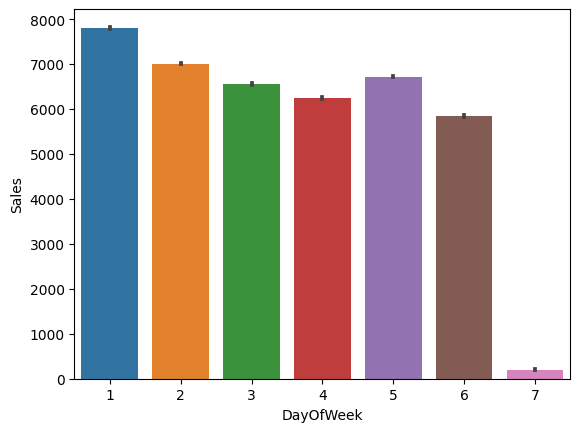

In [54]:
sns.barplot(x='DayOfWeek', y='Sales', data=train)
plt.show()

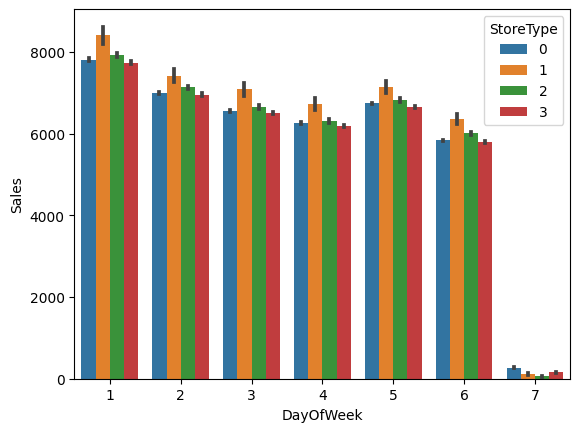

In [55]:
sns.barplot(x='DayOfWeek', y='Sales', hue='StoreType', data=train)
plt.show()

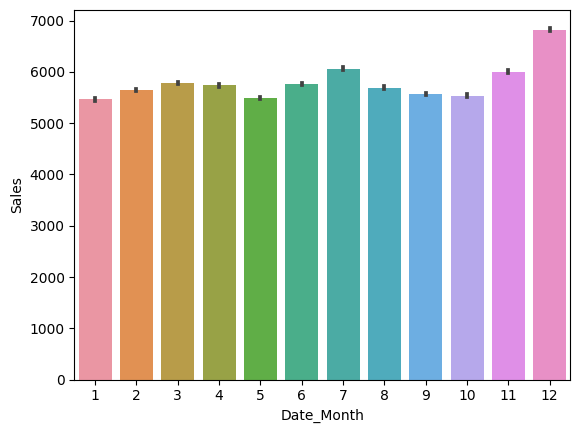

In [56]:
sns.barplot(x='Date_Month', y='Sales', data=train)
plt.show()

-> Die Umsätze sind im Dezember und Juli durschnittlich höher als im Rest des Jahres.

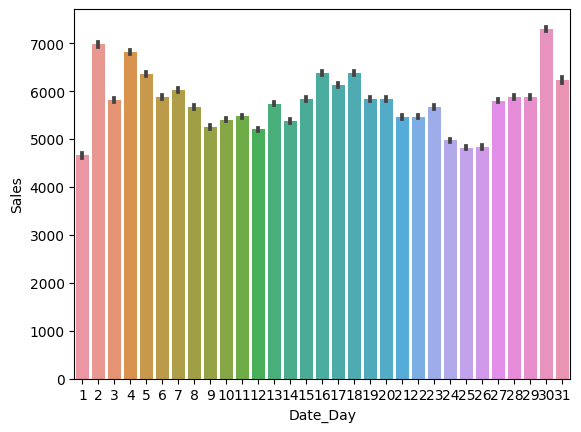

In [57]:
sns.barplot(x='Date_Day', y='Sales', data=train)
plt.show()

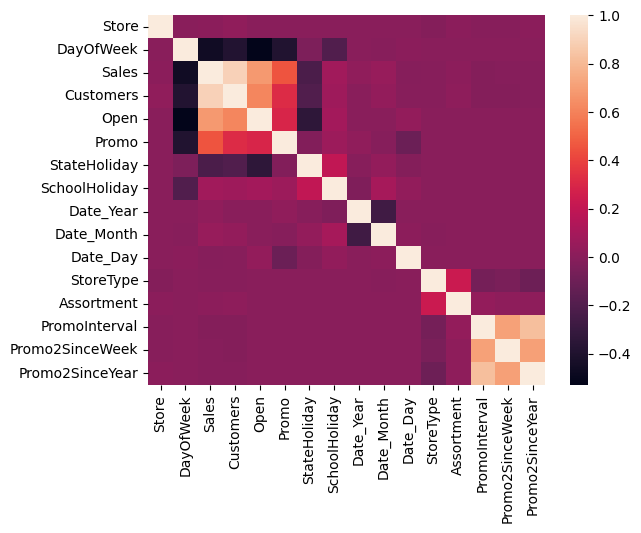

In [58]:
corr = train.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

> Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday haben eine hohe bis mäßig positive Korrelation mit Sales.

> Der Wochentag korreliert negativ mit Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday.

# Modelling

```X = train.drop(['Sales', 'Customers'], axis=1)
y = train['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
```

scaling notwendig?

In [59]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['Sales', 'Customers'], axis=1),
                                                    train['Sales'],
                                                    test_size=0.2,
                                                    random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)



(813013, 14)
(203254, 14)
(813013,)
(203254,)


In [60]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('RMSE = {:0.2f}'.format(np.sqrt(mean_squared_error(test_labels, predictions))))


def train_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    print('Training set score: {:.2f}'.format(model.score(X_train, y_train)))
    print('Test set score: {:.2f}'.format(model.score(X_test, y_test)))
    evaluate(model, X_test, y_test)
    
    return model

In [61]:
# defining a function to plot feature importance
def plot_feature_importance(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.show()


## k-Nearest Neighbors

In [62]:
# create a k-nearest neighbors regressor using tqdm to show progress
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=3)

# train and evaluate the model
knn = train_evaluate(knn, X_train, y_train, X_test, y_test)

Training set score: 0.87
Test set score: 0.70
Average Error: 1403.7431 degrees.
RMSE = 2123.27


## Logistic Regression

In [63]:
# create a logistic regression model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

# train and evaluate the model
lr = train_evaluate(lr, X_train, y_train, X_test, y_test)

Training set score: 0.54
Test set score: 0.54
Average Error: 1773.5748 degrees.
RMSE = 2613.32


## Random Forest

Training set score: 0.97
Test set score: 0.86
Average Error: 802.4904 degrees.
RMSE = 1458.75


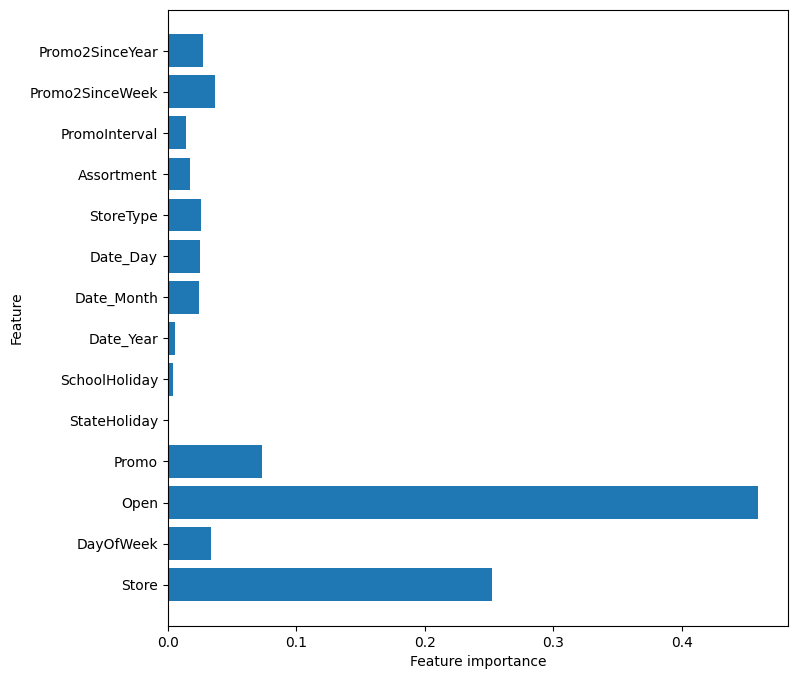

In [64]:
# create a random forest regressor
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=5, random_state=42)

# train and evaluate the model
rf = train_evaluate(rf, X_train, y_train, X_test, y_test)

# plot feature importance
plot_feature_importance(rf)

## Decision Tree

Training set score: 1.00
Test set score: 0.76
Average Error: 973.2167 degrees.
RMSE = 1901.96


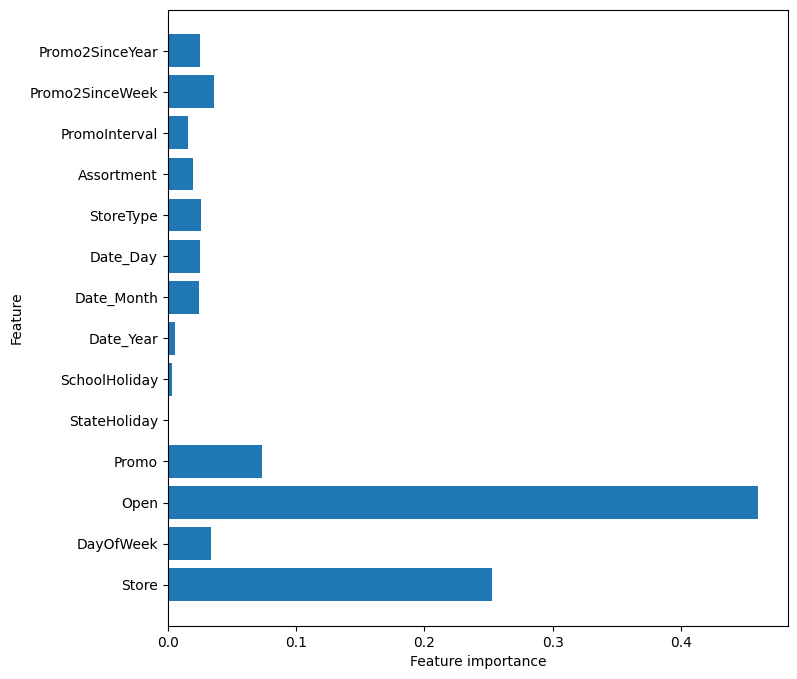

In [65]:
# create a decision tree regressor
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=42)

# train and evaluate the model
dt = train_evaluate(dt, X_train, y_train, X_test, y_test)

# plot feature importance
plot_feature_importance(dt)

## AdaBoost

Training set score: -0.29
Test set score: -0.29
Average Error: 3517.9819 degrees.
RMSE = 4371.52


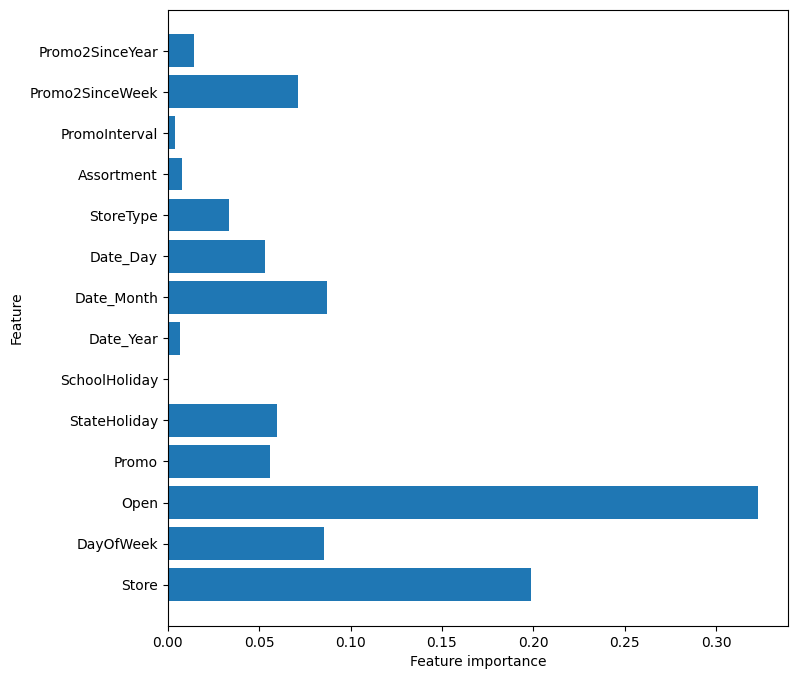

In [66]:
# create an ada boost regressor
from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor(random_state=42)

# train and evaluate the model
ada = train_evaluate(ada, X_train, y_train, X_test, y_test)

# plot feature importance
plot_feature_importance(ada)

## Support Vector Machine

In [67]:
# create a support vector regressor
from sklearn.svm import SVR
svr = SVR(verbose=True, max_iter=10000, tol=0.1, C=1.0, epsilon=0.2)

# train and evaluate the model
svr = train_evaluate(svr, X_train, y_train, X_test, y_test)

[LibSVM].........WARN: libsvm Solver reached max_iter
optimization finished, #iter = 10000
obj = -160038964.434562, rho = -8268.885691
nSV = 19756, nBSV = 19756


/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training set score: -0.42
Test set score: -0.42
Average Error: 3674.5290 degrees.
RMSE = 4587.11


## Gradient Boost

Training set score: 0.63
Test set score: 0.63
Average Error: 1589.0602 degrees.
RMSE = 2330.91


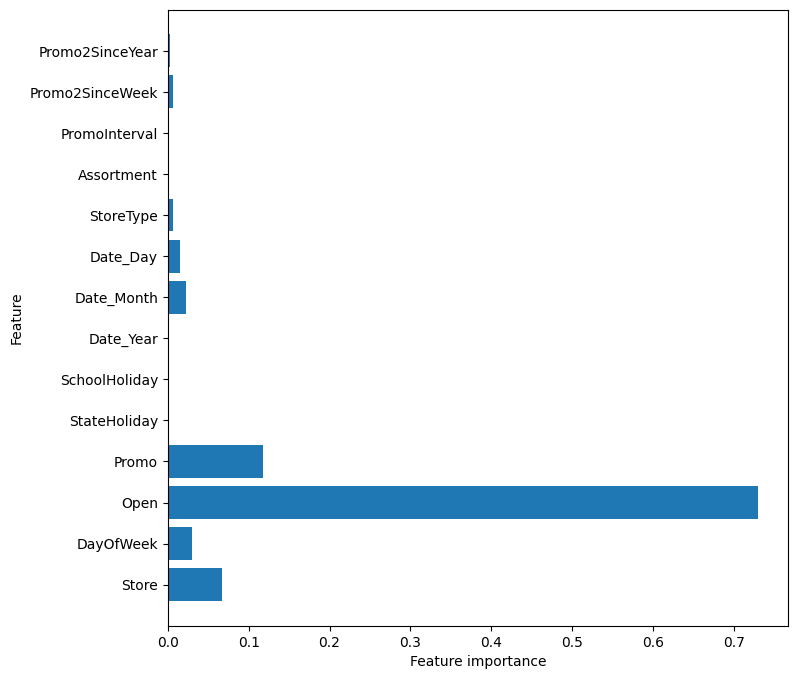

In [68]:
# create a gradient boosting regressor
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(random_state=42)

# train and evaluate the model
gb = train_evaluate(gb, X_train, y_train, X_test, y_test)

# plot feature importance
plot_feature_importance(gb)

## XGBoost

Training set score: 0.89
Test set score: 0.89
Average Error: 903.4969 degrees.
RMSE = 1284.96


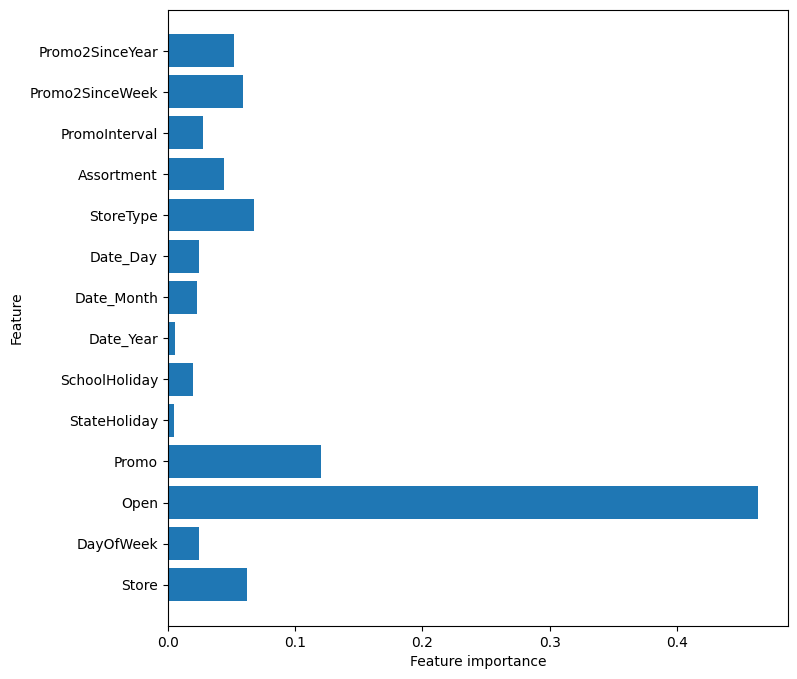

In [69]:
# create a xgboost regressor
import xgboost as xgb
xgb = xgb.XGBRegressor(random_state=42)

# train and evaluate the model
xgb = train_evaluate(xgb, X_train, y_train, X_test, y_test)

# plot feature importance
plot_feature_importance(xgb)

# Hyperparameter Tuning

Zuvor wurden erste Einblicke in die Feature Importance vorgenommen. Bei den Sales der Rossmann stores spielt "Open" selbstverständlich eine Schlüsselrolle. Wäre der einzelne Store geschlossen, gäbe es auch keinen Umsatz. Durchschnittlich spielt "Promo" eine - wenn auch geringe - Rolle. "StateHoliday" und "SchoolHoliday" üben hingegen keinen Einfluss auf den Umsatz aus. Bei AdaBoost und dem Decision Tree Model hat der Store Type einen vergleichsweise hohen Stellenwert. Um die Feature Importance abschließend zu bewerten, werden im nächsten Schritt die Hyperparameter einzelner Modelle optimiert:

Bevor dies geschieht, wurde die Performance der Modelle mit Standardwerten gemessen. Die Ergebnisse sind in der folgenden Tabelle zusammengefasst.
Die performantesten Modelle werden mit GridSearchCV optimiert, erkennbar an dem ☑ in der Spalte "Hyperparameter Tuning?".

| Model      | Performance | Hyperparameter Tuning?     |
| ---:        |    :----   |          :---: |
| k=3-Nearest Neighbors      | Training set score: 0.87<br>Test set score: 0.70<br>Average Error: 1403.7431 degrees.<br>RMSE = 2123.27| ☑ |
| Logistic Regression   |Training set score: 0.54<br>Test set score: 0.54<br>Average Error: 1773.5748 degrees.<br>RMSE = 2613.32|ist im Mittelfeld, daher (vorerst nicht)|
| Random Forest   |Training set score: 0.97<br>Test set score: 0.86<br>Average Error: 802.4904 degrees.<br>RMSE = 1458.75| ☑ |
| Decision Tree   |Training set score: 1.00<br>Test set score: 0.76<br>Average Error: 973.2167 degrees.<br>RMSE = 1901.96| ☑ |
| AdaBoost   |Training set score: -0.29<br>Test set score: -0.29<br>Average Error: 3517.9819 degrees.<br>RMSE = 4371.52|bildet das Schlusslicht|
| Support Vector Machine   |Training set score: -0.42<br>Test set score: -0.42<br>Average Error: 3674.5290 degrees.<br>RMSE = 4587.11|bildet das Schlusslicht|
| Gradient Boost   |Training set score: 0.63<br>Test set score: 0.63<br>Average Error: 1589.0602 degrees.<br>RMSE = 2330.91|ist im Mittelfeld, daher (vorerst nicht)|
| XGBoost   |Training set score: 0.89<br>Test set score: 0.89<br>Average Error: 903.4969 degrees.<br>RMSE = 1284.96| ☑ |

Nach der Optimierung soll die Performance der einzelnen Modelle mit den Testdaten gemessen werden. Außerdem wird die Feature Importance der einzelnen Modelle nochmals betrachtet. 

## k-Nearest Neighbors

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'n_neighbors': 2}
0.6620100794329739
KNeighborsRegressor(n_neighbors=2)
1
{'mean_fit_time': array([0.52083488, 0.50066376, 0.50119162, 0.50382166, 0.50274529,
       0.50557342, 0.54383922, 0.55621514, 0.54227481, 0.54255185,
       0.54172773, 0.54994044, 0.54566584, 0.54552026, 0.54370065,
       0.54186473, 0.54245706, 0.5439106 , 0.54638681, 0.54250951,
       0.54365721, 0.54239111, 0.54576049, 0.54392061]), 'std_fit_time': array([0.03121319, 0.00662582, 0.0055753 , 0.00715289, 0.00611657,
       0.00510498, 0.04946051, 0.02121554, 0.00683237, 0.00940167,
       0.00627688, 0.02106544, 0.00767759, 0.00496833, 0.00768196,
       0.00677666, 0.00682075, 0.00648992, 0.00862282, 0.00659545,
       0.007326  , 0.00820216, 0.00845772, 0.007198  ]), 'mean_score_time': array([2.35554633, 2.61141047, 2.92822299, 3.24477744, 3.47929835,
       3.71059217, 4.11167231, 4.37994418, 4.44963431, 4.63588939,
       4.802285  , 4.94820

100%|██████████| 24/24 [12:10<00:00, 30.43s/it]


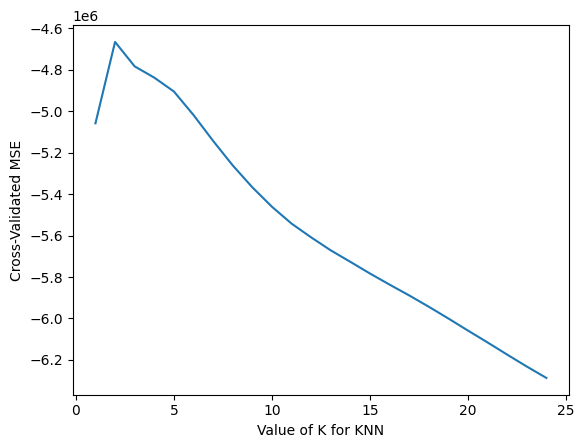

In [71]:
# parameter tuning for knn with tqdm
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# create a k-nearest neighbors regressor
knn = KNeighborsRegressor()

# create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}

# use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=5, verbose=1)

# fit model to data
knn_gscv.fit(X_train, y_train)

# check top performing n_neighbors value
print(knn_gscv.best_params_)
print(knn_gscv.best_score_)
print(knn_gscv.best_estimator_)
print(knn_gscv.best_index_)
print(knn_gscv.cv_results_)
print(knn_gscv.scorer_)
print(knn_gscv.n_splits_)
print(knn_gscv.refit_time_)
print(knn_gscv.score(X_test, y_test))

#plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
k_range = range(1, 25)
k_scores = []
for k in tqdm(k_range):
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    k_scores.append(scores.mean())

plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated MSE')
plt.show()

best neighbors: 2,
best n_splits: 5